## Train CFM

### 1. Forward transport SB1->SB2

In [7]:
import numpy as np
import torch
from DynGenModels.configs.lhco_configs import LHCOlympics_LowLevel_MLP_CondFlowMatch as Configs

configs_fwd = Configs(# data:
                  DATA = 'LHCOlympicsLowLevel',
                  dataset = '../../data/LHCOlympics2020/events_anomalydetection_low_level_4mom.h5', 
                  cuts_sideband_low = {'mjj': [2900, 3300]},  #{'mjj': [2700, 3300]},  
                  cuts_sideband_high = {'mjj': [3700, 4100]}, #{'mjj': [3800, 6000]}, 
                  preprocess = ['normalize'],
                  dim_input = 8,
                  num_dijets = 66650,  
                  # training params:   
                  DEVICE = 'cuda:1',
                  EPOCHS = 100,
                  batch_size = 512,
                  print_epochs = 20,
                  early_stopping = 30,
                  min_epochs = 200,
                  exchange_target_with_source = False,
                  data_split_fracs = [0.85, 0.15, 0.0],
                  lr = 1e-3,
                  optimizer = 'Adam',
                  fix_seed = 12345,
                  # model params:
                  DYNAMICS = 'OptimalTransportFlowMatching', 
                  MODEL = 'MLP_fwd',
                  dim_hidden = 256,
                  dim_time_emb = 64,
                  num_layers = 5,
                  activation = 'ReLU',
                  sigma = 0.00001,
                  t0 = 0.0,
                  t1 = 1.0,
                  # sampling params:
                  solver = 'midpoint',
                  num_sampling_steps = 1000
                )

configs_fwd.set_workdir(path='../../results', save_config=True)

#================================================================================================================
INFO: created directory: ../../results/LHCOlympicsLowLevel.OptimalTransportFlowMatching.MLP_fwd.2023.11.27_17h58
#================================================================================================================
+-----------------------------+------------------------------------------------------------------------+
| Parameters                  | Values                                                                 |
+-----------------------------+------------------------------------------------------------------------+
| DATA                        | LHCOlympicsLowLevel                                                    |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_low_level_4mom.h5   |
| features                    | ['px_j1', 'py_j1', 'pz_j1', 'e_j1', 'px_j2', 'py_j2', 'pz_j2', 'e_j2'] |
| dim_input                  

In [8]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsLowLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

import torch
import numpy as np
import matplotlib.pyplot as plt

lhco_fwd = LHCOlympicsLowLevelDataset(configs_fwd)
cfm_fwd  = DynGenModelTrainer(dynamics = OptimalTransportFlowMatching(configs_fwd),
                              model = MLP(configs_fwd), 
                              dataloader = LHCOlympicsDataLoader(lhco_fwd, configs_fwd), 
                              configs = configs_fwd)

#...train model:

cfm_fwd.train()

number of training parameters: 218888
number of training parameters: 218888
number of training parameters: 218888
number of training parameters: 218888
start training...
start training...
start training...
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.85/0.15/0.0
INFO: train size: 56652, validation size: 9997, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

	Epoch: 1, train loss: 0.0029420699727058675, valid loss: 0.0030230760108679536  (min valid loss: 0.0030230760108679536)
	Epoch: 1, train loss: 0.0029420699727058675, valid loss: 0.0030230760108679536  (min valid loss: 0.0030230760108679536)
	Epoch: 1, train loss: 0.0029420699727058675, valid loss: 0.0030230760108679536  (min valid loss: 0.0030230760108679536)
	Epoch: 1, train loss: 0.0029420699727058675, valid loss: 0.0030230760108679536  (min valid loss: 0.0030230760108679536)
	Epoch: 21, train loss: 0.0026701701351919695, valid loss: 0.0027102607302367685  (min valid loss: 0.0027102607302367685)
	Epoch: 21, train loss: 0.0026701701351919695, valid loss: 0.0027102607302367685  (min valid loss: 0.0027102607302367685)
	Epoch: 21, train loss: 0.0026701701351919695, valid loss: 0.0027102607302367685  (min valid loss: 0.0027102607302367685)
	Epoch: 21, train loss: 0.0026701701351919695, valid loss: 0.0027102607302367685  (min valid loss: 0.0027102607302367685)
	Epoch: 41, train loss: 0.00

INFO: neural ODE solver with midpoint method and steps=1000


/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")
/home/df630/DynGenModels/experiments/LHCO_olympics/utils.py:158: RuntimeWarning: invalid value encountered in log
  eta_j1, eta_j2 = 0.5 * np.log( (e_j1 + pz_j1) / (e_j1 - pz_j1)), 0.5 * np.log((e_j2 + pz_j2) / (e_j2 - pz_j2))


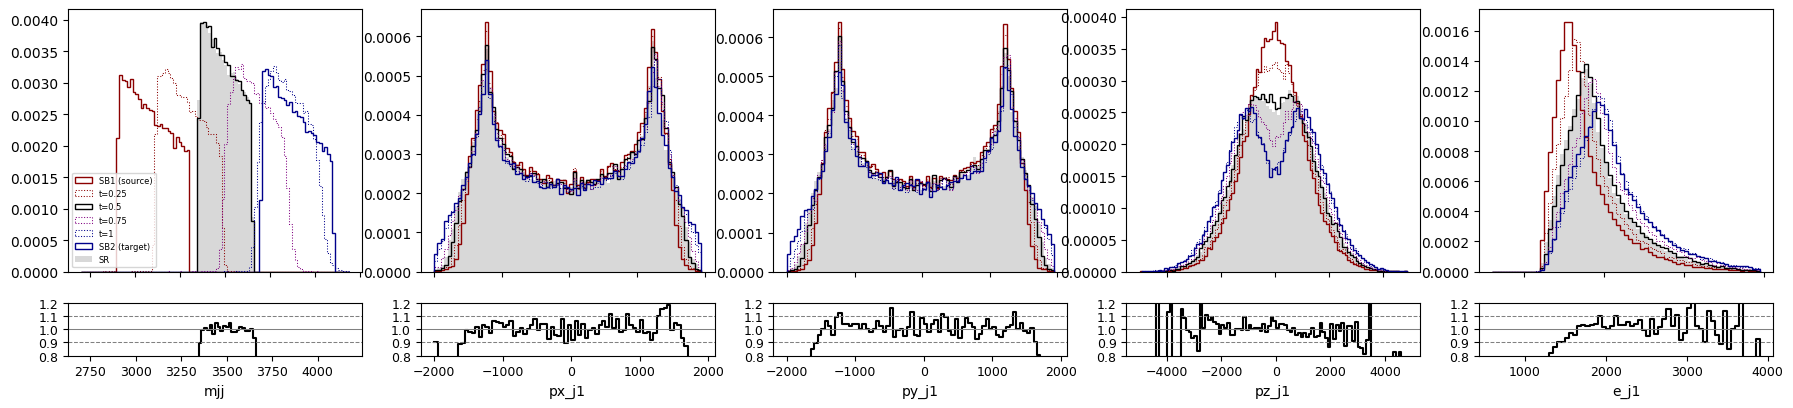

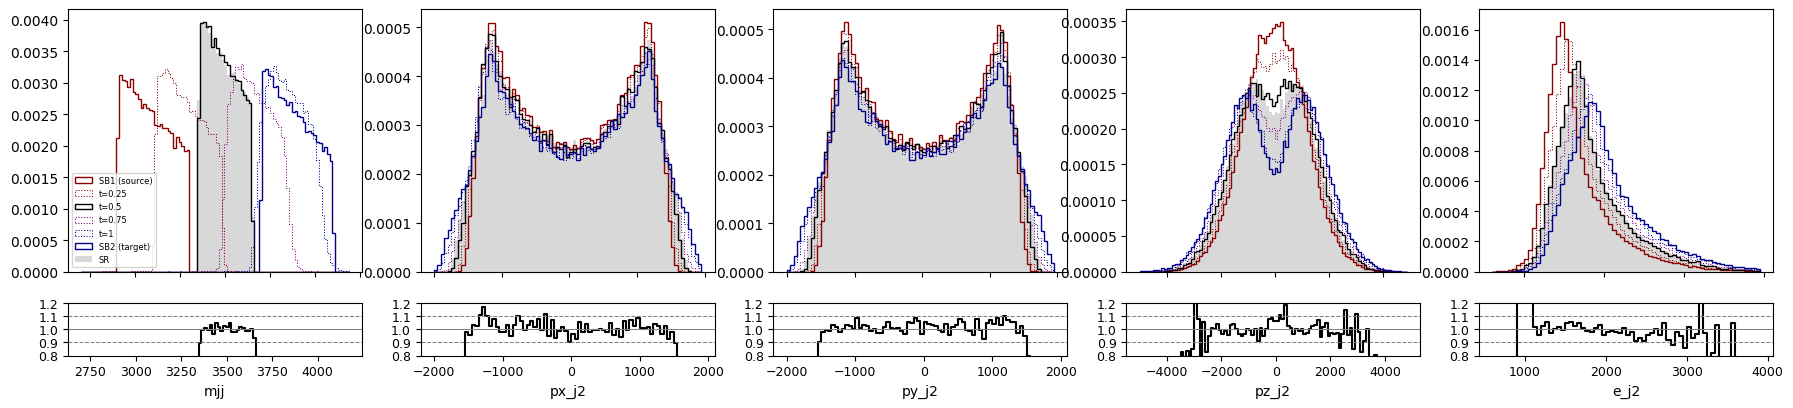

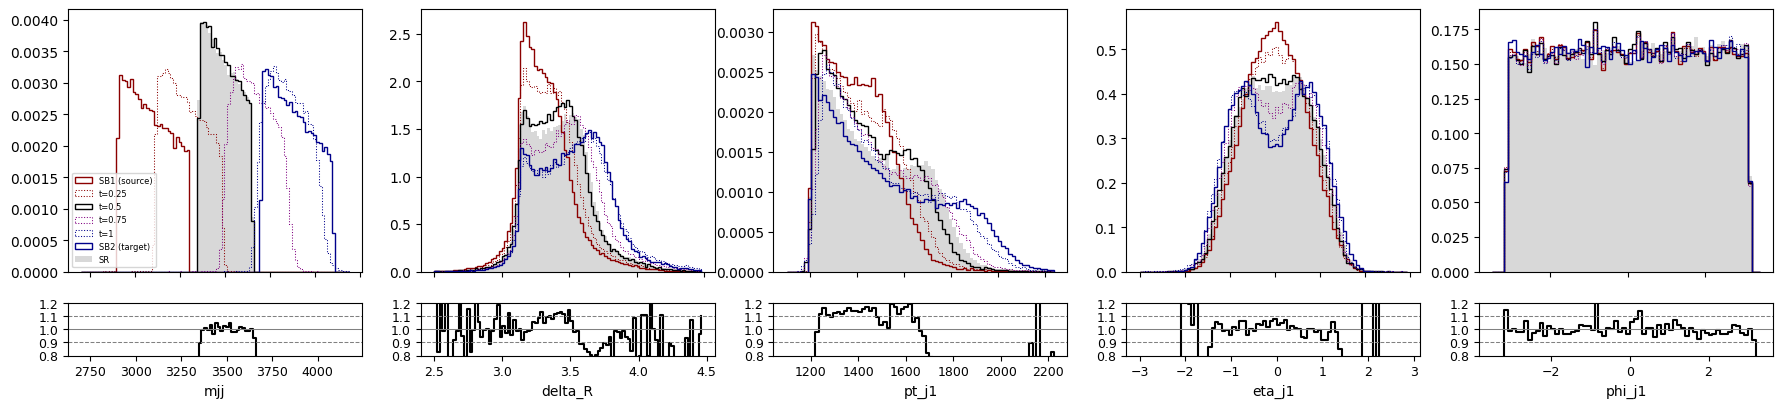

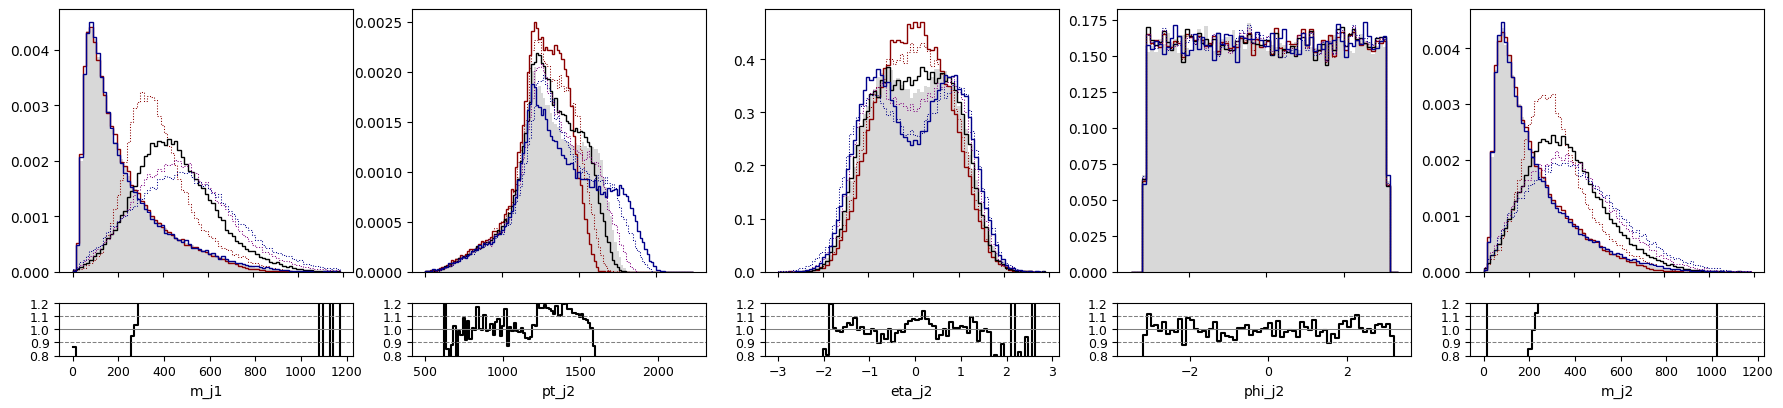

In [3]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsLowLevelData, PostProcessLHCOlympicsLowLevelData

pipeline_fwd = FlowMatchPipeline(trained_model=cfm_fwd, 
                                 configs=configs_fwd, 
                                 preprocessor=PreProcessLHCOlympicsLowLevelData,
                                 postprocessor=PostProcessLHCOlympicsLowLevelData,
                                 best_epoch_model=True,
                                 num_sampling_steps=1000)

pipeline_fwd.generate_samples(input_source=lhco_fwd.source)

from utils import plot_interpolation_low_level

mjj_buffer = 50.0

plot_interpolation_low_level(lhco_fwd, pipeline_fwd, 
                             time_stop_feature='mjj',
                             features=['mjj', 'px_j1', 'py_j1', 'pz_j1', 'e_j1'],
                             bins=[(2700, 4200, 15), (-2000, 2000, 50), (-2000, 2000, 50), (-5000, 5000, 100), (600, 4000, 50)], 
                             figsize=(22, 4.5),
                             mass_window=[configs_fwd.cuts_sideband_low['mjj'][1] + mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][0] - mjj_buffer], 
                             log=False, 
                             density=True,
                             save_path=configs_fwd.workdir+'/interpolation_low_level_j1.png',
                             show=True)


plot_interpolation_low_level(lhco_fwd, pipeline_fwd, 
                             time_stop_feature='mjj',
                             features=['mjj', 'px_j2', 'py_j2', 'pz_j2', 'e_j2'],
                             bins=[(2700, 4200, 15), (-2000, 2000, 50), (-2000, 2000, 50), (-5000, 5000, 100), (600, 4000, 50)], 
                             figsize=(22, 4.5),
                             mass_window=[configs_fwd.cuts_sideband_low['mjj'][1] + mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][0] - mjj_buffer], 
                             log=False, 
                             density=True,
                             save_path=configs_fwd.workdir+'/interpolation_low_level_j2.png',
                             show=True)


plot_interpolation_low_level(lhco_fwd, pipeline_fwd, 
                             time_stop_feature='mjj',
                             features=['mjj', 'delta_R', 'pt_j1', 'eta_j1', 'phi_j1'],
                             bins=[(2700, 4200, 15), (2.5, 4.5, 0.02), (1100, 2250, 15), (-3, 3, 0.075), (-3.5, 3.5, 0.1)], 
                             figsize=(22, 4.5),
                             mass_window=[configs_fwd.cuts_sideband_low['mjj'][1] + mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][0] - mjj_buffer], 
                             log=False, 
                             density=True,
                             save_path=configs_fwd.workdir+'/interpolation_high_level_j1.png',
                             show=True)

plot_interpolation_low_level(lhco_fwd, pipeline_fwd, 
                             time_stop_feature='mjj',
                             features=['m_j1', 'pt_j2', 'eta_j2', 'phi_j2',  'm_j2'],
                             bins=[(0, 1200, 15), (500, 2250, 15), (-3, 3, 0.075), (-3.5, 3.5, 0.1),(0, 1200, 15)], 
                             figsize=(22, 4.5),
                             mass_window=[configs_fwd.cuts_sideband_low['mjj'][1] + mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][0] - mjj_buffer], 
                             log=False, 
                             density=True,
                             save_path=configs_fwd.workdir+'/interpolation_high_level_j2.png',
                             show=True)

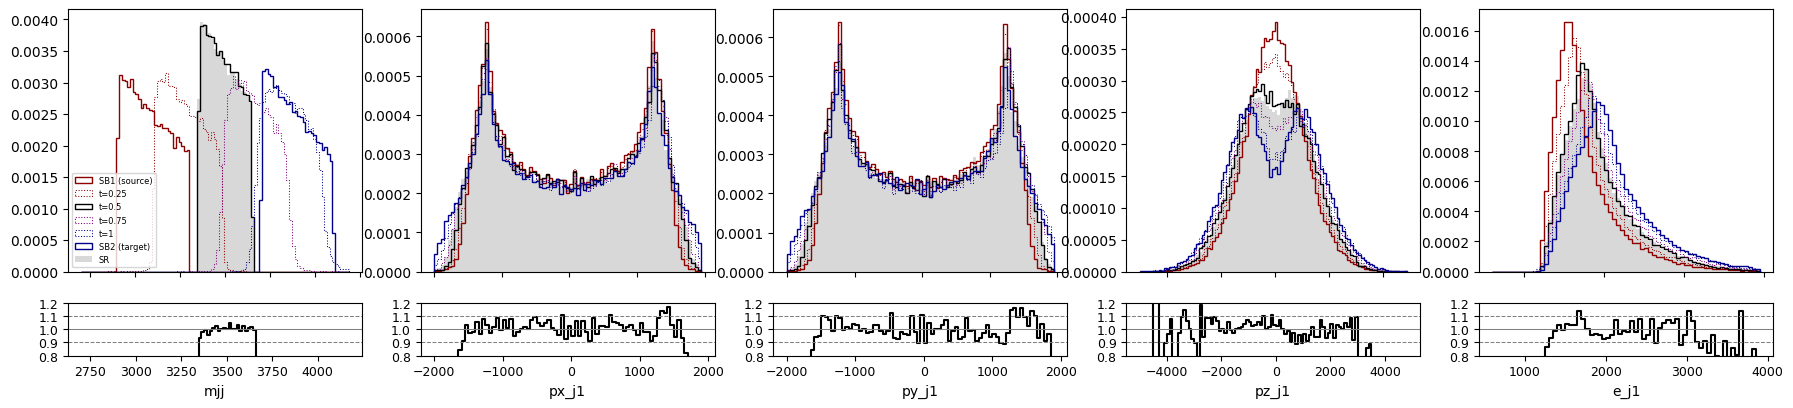

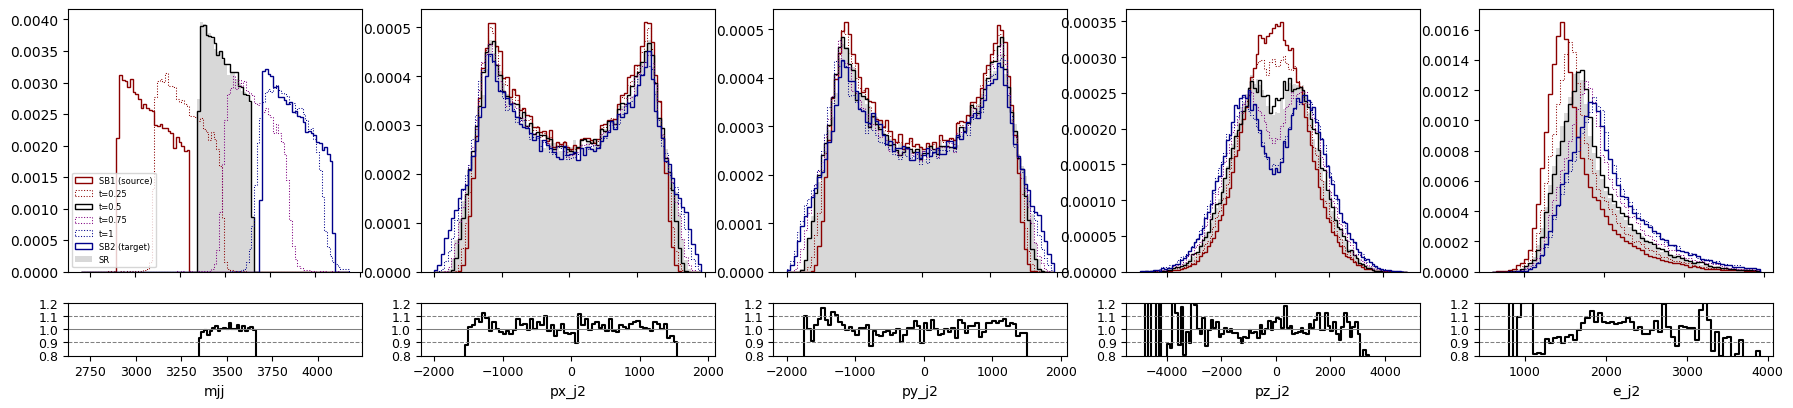

In [9]:
# from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
# from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsLowLevelData, PostProcessLHCOlympicsLowLevelData

# pipeline_fwd = FlowMatchPipeline(trained_model=cfm_fwd, 
#                                  configs=configs_fwd, 
#                                  preprocessor=PreProcessLHCOlympicsLowLevelData,
#                                  postprocessor=PostProcessLHCOlympicsLowLevelData,
#                                  best_epoch_model=True,
#                                  num_sampling_steps=500)

# pipeline_fwd.generate_samples(input_source=lhco_fwd.source)

# from utils import plot_interpolation_low_level

mjj_buffer = 50.0

plot_interpolation_low_level(lhco_fwd, pipeline_fwd, 
                             time_stop_feature='mjj',
                             features=['mjj', 'px_j1', 'py_j1', 'pz_j1', 'e_j1'],
                             bins=[(2700, 4200, 15), (-2000, 2000, 50), (-2000, 2000, 50), (-5000, 5000, 100), (600, 4000, 50)], 
                             figsize=(22, 4.5),
                             mass_window=[configs_fwd.cuts_sideband_low['mjj'][1] + mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][0] - mjj_buffer], 
                             log=False, 
                             density=True,
                             save_path=configs_fwd.workdir+'/interpolation_low_level_j1.png',
                             show=True)


plot_interpolation_low_level(lhco_fwd, pipeline_fwd, 
                             time_stop_feature='mjj',
                             features=['mjj', 'px_j2', 'py_j2', 'pz_j2', 'e_j2'],
                             bins=[(2700, 4200, 15), (-2000, 2000, 50), (-2000, 2000, 50), (-5000, 5000, 100), (600, 4000, 50)], 
                             figsize=(22, 4.5),
                             mass_window=[configs_fwd.cuts_sideband_low['mjj'][1] + mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][0] - mjj_buffer], 
                             log=False, 
                             density=True,
                             save_path=configs_fwd.workdir+'/interpolation_low_level_j2.png',
                             show=True)

/home/df630/DynGenModels/experiments/LHCO_olympics/utils.py:158: RuntimeWarning: invalid value encountered in log
  eta_j1, eta_j2 = 0.5 * np.log( (e_j1 + pz_j1) / (e_j1 - pz_j1)), 0.5 * np.log((e_j2 + pz_j2) / (e_j2 - pz_j2))


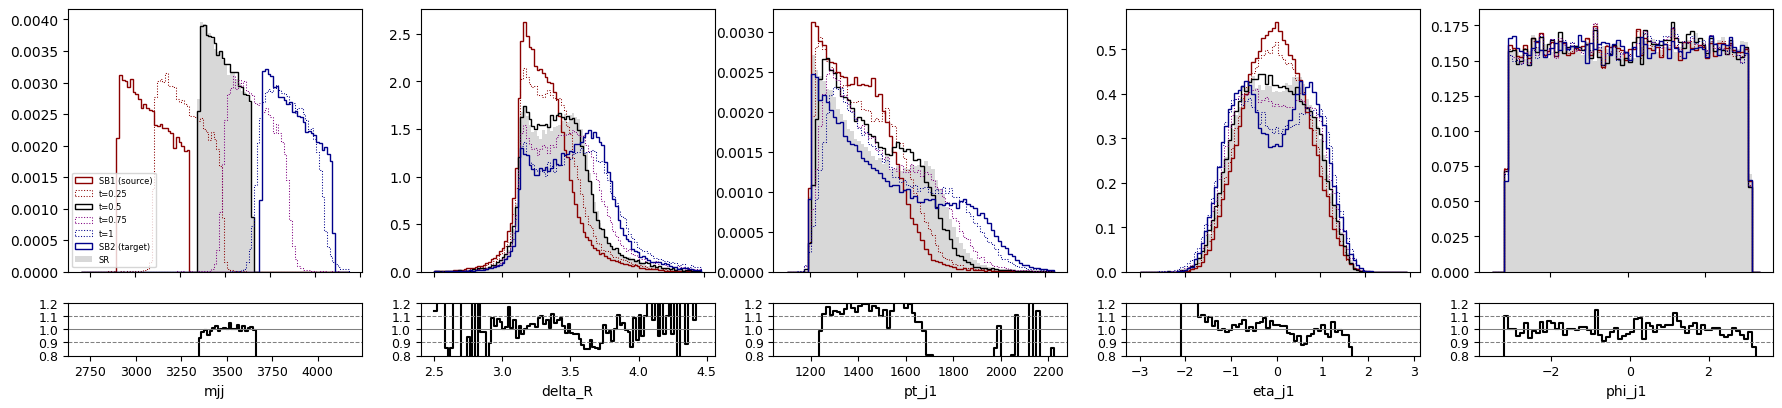

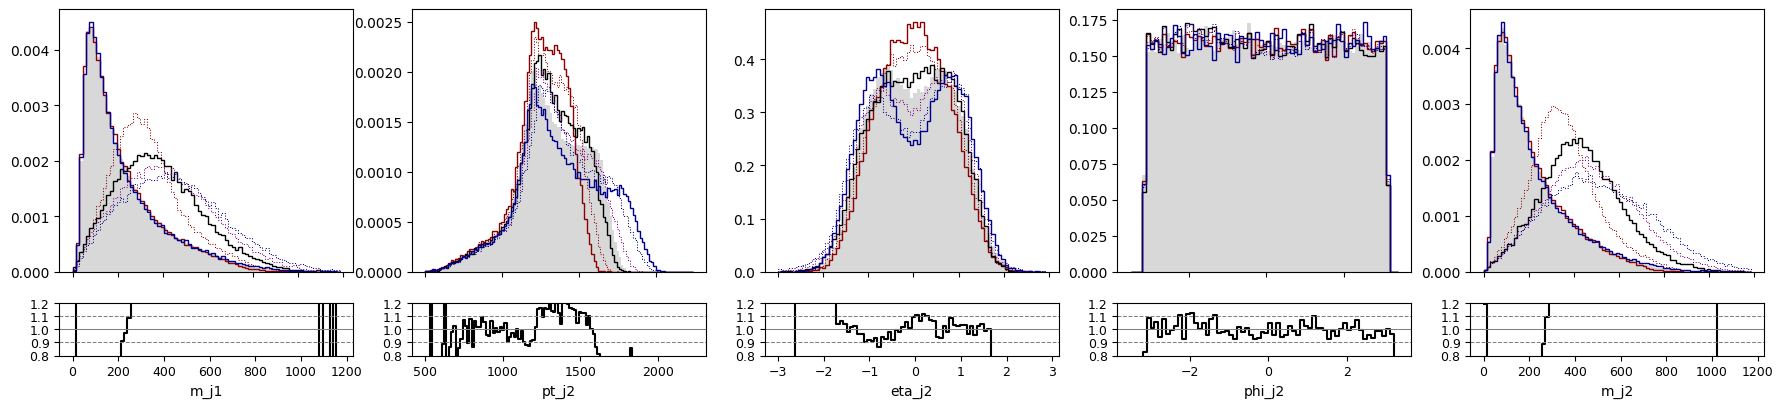

In [11]:
from utils import plot_interpolation_low_level

mjj_buffer = 50.0

plot_interpolation_low_level(lhco_fwd, pipeline_fwd, 
                             time_stop_feature='mjj',
                             features=['mjj', 'delta_R', 'pt_j1', 'eta_j1', 'phi_j1'],
                             bins=[(2700, 4200, 15), (2.5, 4.5, 0.02), (1100, 2250, 15), (-3, 3, 0.075), (-3.5, 3.5, 0.1)], 
                             figsize=(22, 4.5),
                             mass_window=[configs_fwd.cuts_sideband_low['mjj'][1] + mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][0] - mjj_buffer], 
                             log=False, 
                             density=True,
                             save_path=configs_fwd.workdir+'/interpolation_high_level_j1.png',
                             show=True)

plot_interpolation_low_level(lhco_fwd, pipeline_fwd, 
                             time_stop_feature='mjj',
                             features=['m_j1', 'pt_j2', 'eta_j2', 'phi_j2',  'm_j2'],
                             bins=[(0, 1200, 15), (500, 2250, 15), (-3, 3, 0.075), (-3.5, 3.5, 0.1),(0, 1200, 15)], 
                             figsize=(22, 4.5),
                             mass_window=[configs_fwd.cuts_sideband_low['mjj'][1] + mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][0] - mjj_buffer], 
                             log=False, 
                             density=True,
                             save_path=configs_fwd.workdir+'/interpolation_high_level_j2.png',
                             show=True)

### data preprocessing

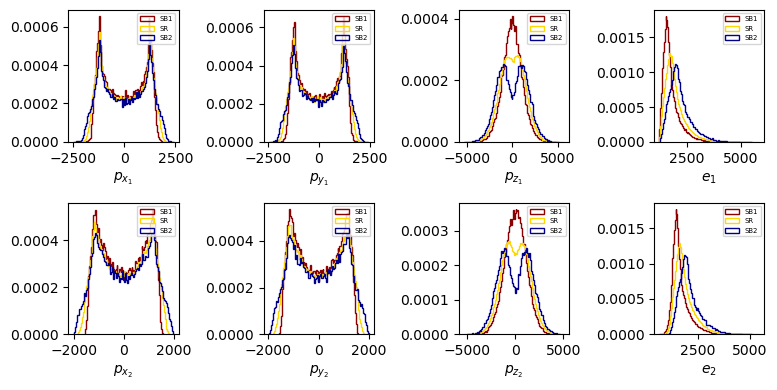

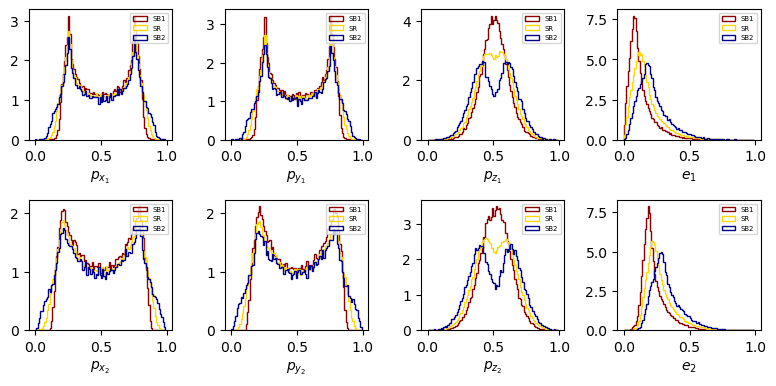

In [34]:
# histogram for featrue:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(lhco_fwd, preprocessed: bool = True):
    fig, axs = plt.subplots(2, 4, figsize=(8, 4))  # Create a 2x4 grid of subplots
    axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing
    bins = np.arange(0, 1, 0.01)
    dic = {0: r'$p_{x_1}$', 1: r'$p_{y_1}$', 2: r'$p_{z_1}$', 3: r'$e_1$', 4: r'$p_{x_2}$', 5: r'$p_{y_2}$', 6: r'$p_{z_2}$', 7: r'$e_2$'}

    for i in range(8):

        if preprocessed:
            bins = np.arange(0, 1, 0.01)
            axs[i].hist(lhco_fwd.source_preprocess[..., i], bins=bins, density=True, label='SB1', histtype='step', color='darkred')
            axs[i].hist(lhco_fwd.background_preprocess[..., i], bins=bins, density=True, label='SR', histtype='step', color='gold')
            axs[i].hist(lhco_fwd.target_preprocess[..., i], bins=bins, density=True, label='SB2', histtype='step', color='darkblue')
        else:
            bins = 100
            axs[i].hist(lhco_fwd.source[..., i], bins=bins, density=True, label='SB1', histtype='step', color='darkred')
            axs[i].hist(lhco_fwd.background[..., i], bins=bins, density=True, label='SR', histtype='step', color='gold')
            axs[i].hist(lhco_fwd.target[..., i], bins=bins, density=True, label='SB2', histtype='step', color='darkblue')

        axs[i].set_xlabel(dic[i])
        axs[i].legend(loc='upper right', fontsize='5')

    plt.tight_layout()  # Adjust the layout
    plt.show()



plot_histograms(lhco_fwd, preprocessed=False)
plot_histograms(lhco_fwd)



In [25]:
import numpy as np


def plot_interpolation_low_level(lhco, pipeline,  mass_window,  subleading=False,  time_stop_feature='mjj', figsize=(12,6), 
                                features=['mjj', 'px_j1', 'py_j1', 'pz_j1', 'e_j1'],
                                bins=[(2700, 4200, 40), (-2000, 2000, 100), (-2000, 2000, 100), (-5000, 5000, 200), (600, 4000, 100)], 
                                log=True, density=True, save_path=None, show=False):    
    dic = {'mjj':0, 'delta_R':1, 'pt_j1':2, 'eta_j1':3, 'phi_j1':4, 'm_j1':5, 'pt_j2':6, 'eta_j2':7, 'phi_j2':8, 'm_j2':9, 
           'px_j1':10, 'py_j1':11, 'pz_j1':12, 'e_j1':13, 'px_j2':14, 'py_j2':15, 'pz_j2':16, 'e_j2':17}

    N = pipeline.num_sampling_steps

    def get_features(features):
        px_j1, py_j1, pz_j1, e_j1 = features[...,0], features[...,1], features[...,2], features[...,3]
        px_j2, py_j2, pz_j2, e_j2 = features[...,4], features[...,5], features[...,6], features[...,7]
        m_j1 = torch.sqrt(e_j1**2 - px_j1**2 - py_j1**2 - pz_j1**2)
        m_j2 = torch.sqrt(e_j2**2 - px_j2**2 - py_j2**2 - pz_j2**2)
        pt_j1,  pt_j2 = torch.sqrt(px_j1**2 + py_j1**2), torch.sqrt(px_j2**2 + py_j2**2)  
        eta_j1, eta_j2 = 0.5 * np.log( (e_j1 + pz_j1) / (e_j1 - pz_j1)), 0.5 * np.log((e_j2 + pz_j2) / (e_j2 - pz_j2))
        phi_j1, phi_j2 = np.arctan2(py_j1, px_j1), np.arctan2(py_j2, px_j2)    
        delta_R = np.sqrt((phi_j1 - phi_j2)**2 + (eta_j1 - eta_j2)**2)   
        mjj = torch.sqrt((e_j1 + e_j2)**2 - (px_j1 + px_j2)**2 - (py_j1 + py_j2)**2 - (pz_j1 + pz_j2)**2) 
        
        all_feats = torch.concat([mjj[:, None], delta_R[:, None],  
                                  pt_j1[:, None], eta_j1[:, None], phi_j1[:, None], m_j1[:, None],
                                  pt_j2[:, None], eta_j2[:, None], phi_j2[:, None], m_j2[:, None],
                                  px_j1[:, None], py_j1[:, None], pz_j1[:, None], e_j1[:, None],
                                  px_j2[:, None], py_j2[:, None], pz_j2[:, None], e_j2[:, None]], dim=-1)
        return all_feats

    source, target, background = get_features(lhco.source), get_features(lhco.target), get_features(lhco.background)
    trajectories = []
    for trajectory in pipeline.trajectories: trajectories.append(get_features(trajectory))
    trajectories = torch.stack(trajectories, dim=0)

    assert time_stop_feature in dic, f'Feature {time_stop_feature} not in {dic.keys()}'
    x = torch.mean(trajectories[...,dic[time_stop_feature]], dim=-1) - background[...,dic[time_stop_feature]].mean()
    idx = torch.argmin(torch.abs(x))
    interpolation = trajectories[idx]  
    mask = (interpolation[...,0] > mass_window[0]) & (interpolation[...,0] < mass_window[1])
    mask_back = (background[...,0] > mass_window[0]) & (background[...,0] < mass_window[1])

    fig, axs = plt.subplots(2, len(features), figsize=figsize, gridspec_kw={'height_ratios': [len(features), 1]})
    
    for i,f in enumerate([dic[f] for f in features if f in dic]):
        b = np.arange(*bins[i])
        
        # First row: Plotting the ratio of histograms
        ax = axs[0, i]
        ax.hist(source[...,f], bins=b, histtype='step', color='darkred', label='SB1 (source)', log=log, density=density)
        ax.hist(trajectories[N//4][...,f], bins=b, histtype='step', color='darkred', ls=':', lw=0.75, label='t=0.25', log=log, density=density)
        ax.hist(interpolation[mask][...,f], bins=b, histtype='step', color='k', label='t=0.5', log=log, density=density)
        ax.hist(trajectories[3*N//4][...,f], bins=b, histtype='step', color='purple', ls=':', lw=0.75, label='t=0.75', log=log, density=density)
        ax.hist(trajectories[-1][...,f], bins=b, histtype='step', color='darkblue', ls=':', lw=0.75, label='t=1',log=log, density=density)
        ax.hist(target[...,f], bins=b, histtype='step', color='darkblue',  label='SB2 (target)', log=log, density=density)
        ax.hist(background[mask_back][...,f],bins=b, histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=log, density=density)
        ax.set_xticklabels([])   
        if f == 0: ax.legend(loc='lower left', fontsize=6)

        # Second row: Plotting the ratio of histograms
        counts_interpolation, _ = np.histogram(interpolation[mask][...,f], bins=b, density=density)
        counts_background, _ = np.histogram(background[mask_back][...,f], bins=b, density=density)
        ratio_interpolation = np.divide(counts_interpolation, counts_background, out=np.zeros_like(counts_interpolation), where=counts_background!=0)

        ax_ratio = axs[1, i]
        ax_ratio.plot(b[:-1], ratio_interpolation, drawstyle='steps-post', color='k')
        ax_ratio.set_ylim(0.8, 1.2, 0) 
        ax_ratio.set_xlabel(features[i])
        ax_ratio.axhline(1, color='gray', linestyle='-', lw=0.75)
        ax_ratio.axhline(0.9, color='gray', linestyle='--', lw=0.75)
        ax_ratio.axhline(1.1, color='gray', linestyle='--', lw=0.75)

        for tick in ax_ratio.xaxis.get_major_ticks(): tick.label.set_fontsize(9)
        for tick in ax_ratio.yaxis.get_major_ticks(): tick.label.set_fontsize(9)  
        ax_ratio.set_yticks([0.8,  0.9,  1,  1.1,  1.2])
    
    if save_path is not None: plt.savefig(save_path)
    if show: plt.show()
    plt.close()


### 2. Backward transport SB2->SB1

In [3]:
import numpy as np
import torch
from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs

configs_bwd = Configs(# data:
                  DATA = 'LHCOlympics',
                  dataset = '../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 
                  cuts_sideband_low = {'mjj': [2600, 3300]},  #{'mjj': [2700, 3300]},  
                  cuts_sideband_high = {'mjj': [3700, 13000]}, #{'mjj': [3800, 6000]}, 
                  preprocess = ['normalize'],
                  dim_input = 5,
                  num_dijets = 143871, #66650,  
                  # training params:   
                  DEVICE = 'cpu',
                  EPOCHS = 100,
                  batch_size = 512,
                  print_epochs = 20,
                  early_stopping = 30,
                  min_epochs = 200,
                  exchange_target_with_source = True,
                  data_split_fracs = [0.9, 0.1, 0.0],
                  lr = 5e-4,
                  optimizer = 'Adam',
                  fix_seed = 1234,
                  # model params:
                  DYNAMICS = 'OptimalTransportFlowMatching', 
                  MODEL = 'MLP_bwd',
                  dim_hidden = 256,
                  num_layers = 3,
                  sigma = 0.0,
                  t0 = 0.0,
                  t1 = 1.0,
                  # sampling params:
                  solver = 'midpoint',
                  num_sampling_steps = 1000
                )

configs_bwd.set_workdir(path='../../results', save_config=True)

#========================================================================================================
INFO: created directory: ../../results/LHCOlympics.OptimalTransportFlowMatching.MLP_bwd.2023.11.25_23h24
#========================================================================================================
+-----------------------------+--------------------------------------------------------------------------+
| Parameters                  | Values                                                                   |
+-----------------------------+--------------------------------------------------------------------------+
| DATA                        | LHCOlympics                                                              |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features                    | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input                   | 5        

In [4]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco_bwd = LHCOlympicsHighLevelDataset(configs_bwd, exchange_target_with_source=True)
cfm_bwd = DynGenModelTrainer(dynamics = OptimalTransportFlowMatching(configs_bwd),
                         model = MLP(configs_bwd), 
                         dataloader = LHCOlympicsDataLoader(lhco_bwd, configs_bwd), 
                         configs = configs_bwd)

#...train model:

cfm_bwd.train()

number of training parameters: 134661
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.9/0.1/0.0
INFO: train size: 129483, validation size: 14387, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

	Epoch: 1, train loss: 0.001961953018188271, valid loss: 0.0022179599658682424  (min valid loss: 0.002053728463642042)
	Epoch: 21, train loss: 0.0017785635466683713, valid loss: 0.001855955784337531  (min valid loss: 0.001855955784337531)
	Epoch: 41, train loss: 0.0017756902103831362, valid loss: 0.001838844558545228  (min valid loss: 0.0018340327359479048)
	Epoch: 61, train loss: 0.0017560391434700247, valid loss: 0.00184009508390365  (min valid loss: 0.0018316369728538493)
	Epoch: 81, train loss: 0.001758627942763269, valid loss: 0.001845237943504391  (min valid loss: 0.0018272070045550835)


INFO: neural ODE solver with midpoint method and steps=1000


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


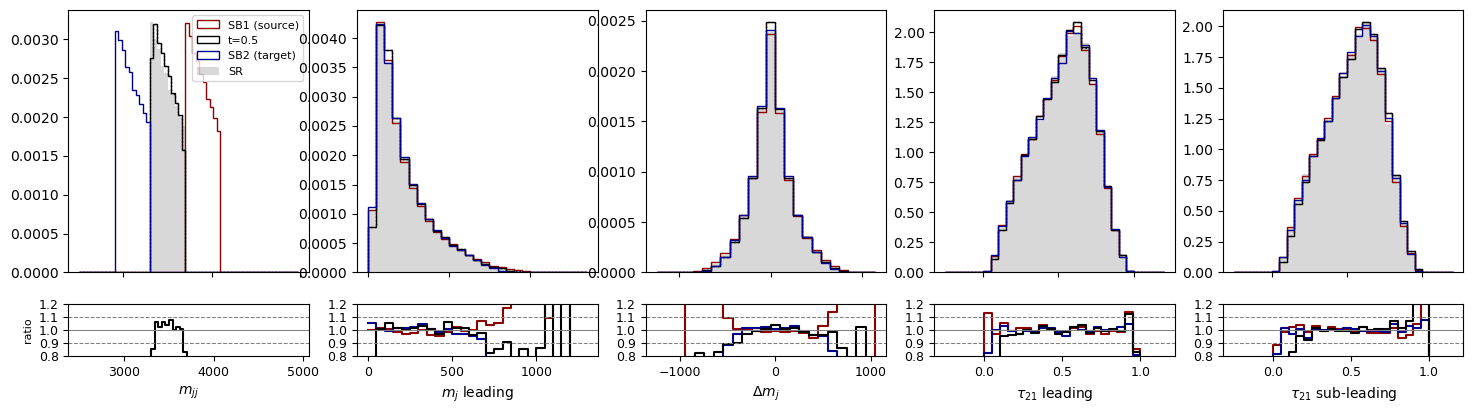

In [7]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline_bwd = FlowMatchPipeline(trained_model=cfm_bwd, 
                                configs=configs_bwd, 
                                preprocessor=PreProcessLHCOlympicsHighLevelData,
                                postprocessor=PostProcessLHCOlympicsHighLevelData,
                                best_epoch_model=True)

pipeline_bwd.generate_samples(input_source=lhco_bwd.source)

from utils import plot_interpolation

plot_interpolation(lhco_bwd, 
                   pipeline_bwd, 
                   figsize=(18,4.5),
                   mass_window=[configs_bwd.cuts_sideband_low['mjj'][1], configs_bwd.cuts_sideband_high['mjj'][0]], 
                   bins=[(2500, 5000, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                   log=False, 
                   density=True)

INFO: neural ODE solver with midpoint method and steps=1000


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


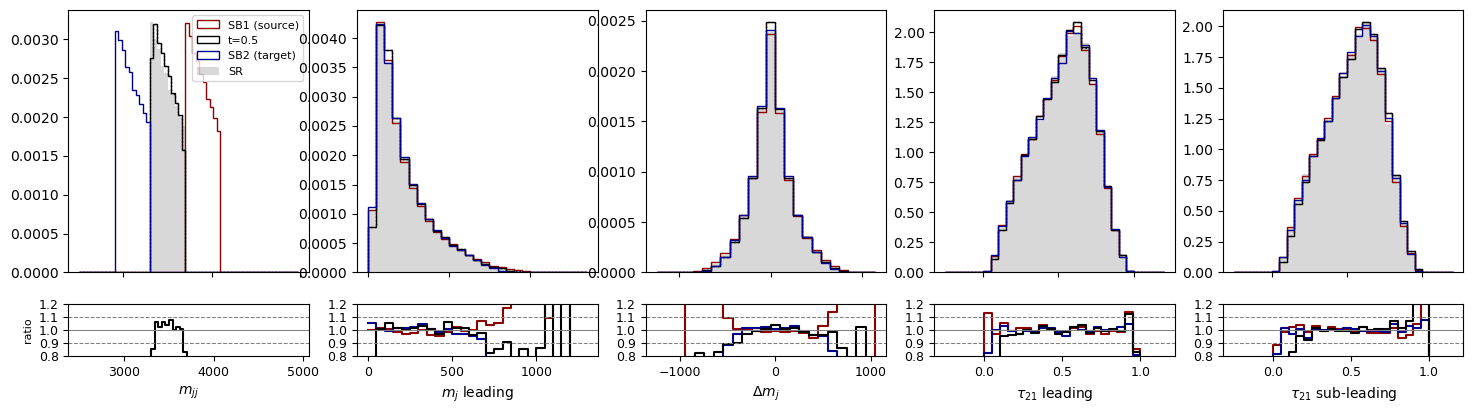

In [8]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline_bwd = FlowMatchPipeline(trained_model=cfm_bwd, 
                                configs=configs_bwd, 
                                preprocessor=PreProcessLHCOlympicsHighLevelData,
                                postprocessor=PostProcessLHCOlympicsHighLevelData,
                                best_epoch_model=True)

pipeline_bwd.generate_samples(input_source=lhco_bwd.source)

from utils import plot_interpolation

plot_interpolation(lhco_bwd, 
                   pipeline_bwd, 
                   figsize=(18,4.5),
                   mass_window=[configs_bwd.cuts_sideband_low['mjj'][1], configs_bwd.cuts_sideband_high['mjj'][0]], 
                   bins=[(2500, 5000, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                   log=False, 
                   density=True)

# Sample from Pretrained CFM

Load a previsoiusly trained model that was stored somewhere in a directory. The directory must contain the follwing files:
- `config.json` file with all the parameters used during the training.
- `best_epoch_model.pth` model file corresponding the trained model that had the lowest validation loss.
- `last_epoch_model.pth` model file corresponding the last epoch trained model.


### Load pre-trained model and generate samples

### Optimal Transport

In [8]:

from DynGenModels.configs.lhco_configs import LHCOlympics_LowLevel_MLP_CondFlowMatch as Configs
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsLowLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching

model_fwd = '../../results/LHCOlympicsLowLevel.OptimalTransportFlowMatching.MLP_fwd.2023.11.27_13h55'

configs_fwd = Configs().load(model_fwd + '/config.json')
configs_fwd.DEVICE = 'cuda:1' 
configs_fwd.workdir = model_fwd 
lhco_fwd = LHCOlympicsLowLevelDataset(configs_fwd)
cfm_fwd  = DynGenModelTrainer(dynamics = OptimalTransportFlowMatching(configs_fwd),
                                model = MLP(configs_fwd), 
                                dataloader = LHCOlympicsDataLoader(lhco_fwd , configs_fwd), 
                                configs = configs_fwd)
cfm_fwd.load(model='best')

+-----------------------------+------------------------------------------------------------------------+
| Parameters                  | Values                                                                 |
+-----------------------------+------------------------------------------------------------------------+
| DATA                        | LHCOlympicsLowLevel                                                    |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_low_level_4mom.h5   |
| features                    | ['px_j1', 'py_j1', 'pz_j1', 'e_j1', 'px_j2', 'py_j2', 'pz_j2', 'e_j2'] |
| dim_input                   | 8                                                                      |
| exchange_target_with_source | False                                                                  |
| preprocess                  | ['normalize']                                                          |
| cuts_sideband_low           | mjj: [2900, 3300]      

In [9]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsLowLevelData, PostProcessLHCOlympicsLowLevelData

pipeline_fwd = FlowMatchPipeline(trained_model=cfm_fwd, 
                                configs=configs_fwd, 
                                preprocessor=PreProcessLHCOlympicsLowLevelData,
                                postprocessor=PostProcessLHCOlympicsLowLevelData,
                                num_sampling_steps=500,
                                best_epoch_model=True)

pipeline_fwd.generate_samples(input_source=lhco_fwd.source)


INFO: neural ODE solver with midpoint method and steps=500


In [ ]:
from utils import load_bridge_pipelines
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching

model_fwd = '../../results/LHCOlympicsLowLevel.OptimalTransportFlowMatching.MLP_forward.2023.11.27_12h18'

pipe_fwd, pipe_bwd, lhco_fwd, lhco_bwd = load_bridge_pipelines(bridge=OptimalTransportFlowMatching,
                                                               model_fwd=model_fwd, 
                                                               model_bwd=None, 
                                                               device='cuda:1')


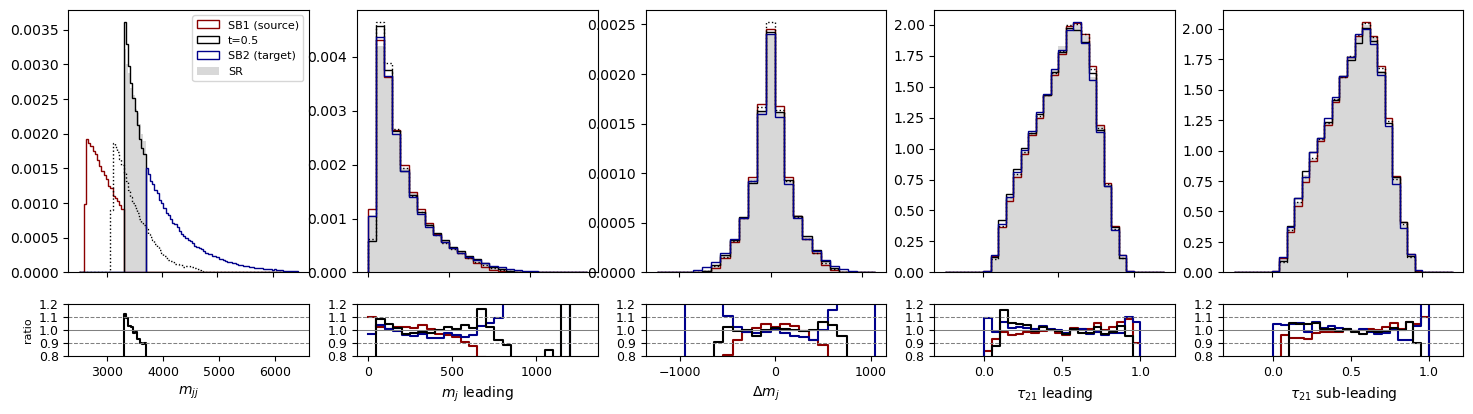

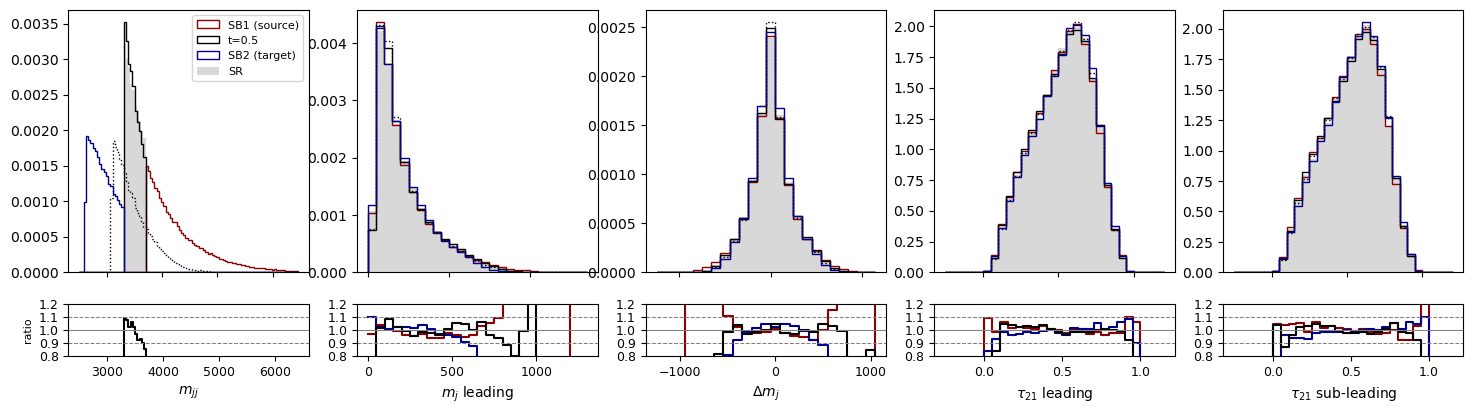

In [20]:
from utils import plot_interpolation

plot_interpolation(lhco_fwd, 
                   pipe_fwd, 
                   figsize=(18,4.5),
                   mass_window=[3300, 3700], 
                   bins=[(2500, 6500, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                   log=False, 
                   density=True)

plot_interpolation(lhco_bwd, 
                   pipe_bwd, 
                   figsize=(18,4.5),
                   mass_window=[3300, 3700], 
                   bins=[(2500, 6500, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                   log=False, 
                   density=True)

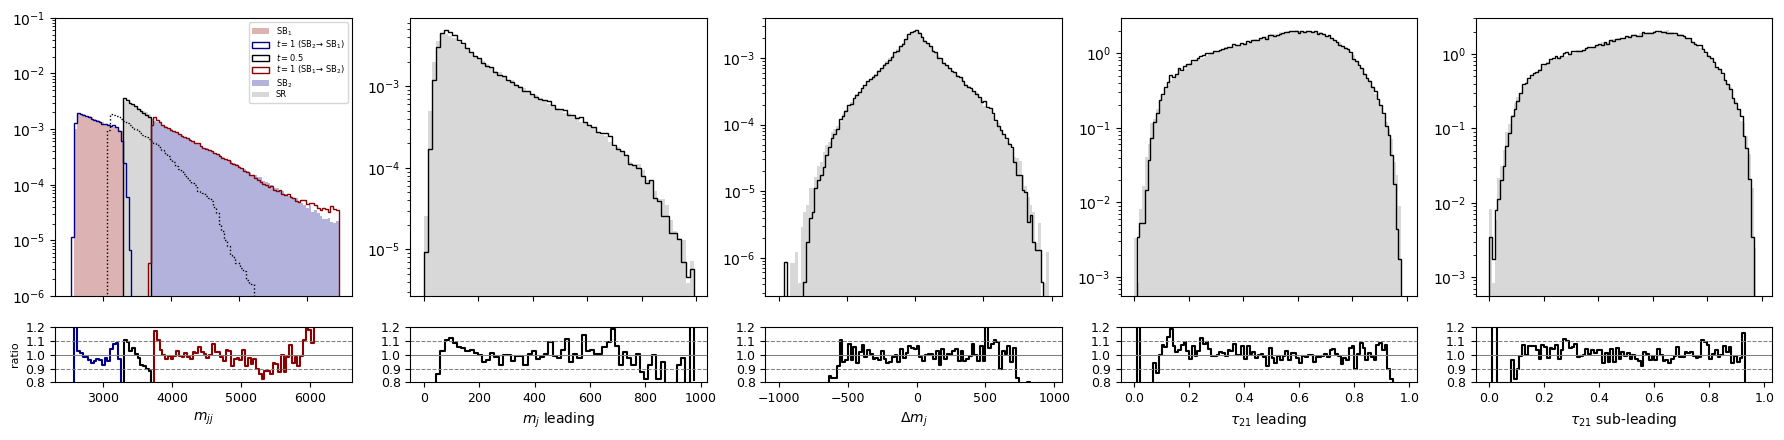

$t_f=$0.4020000100135803, $t_b=0.5910000205039978$


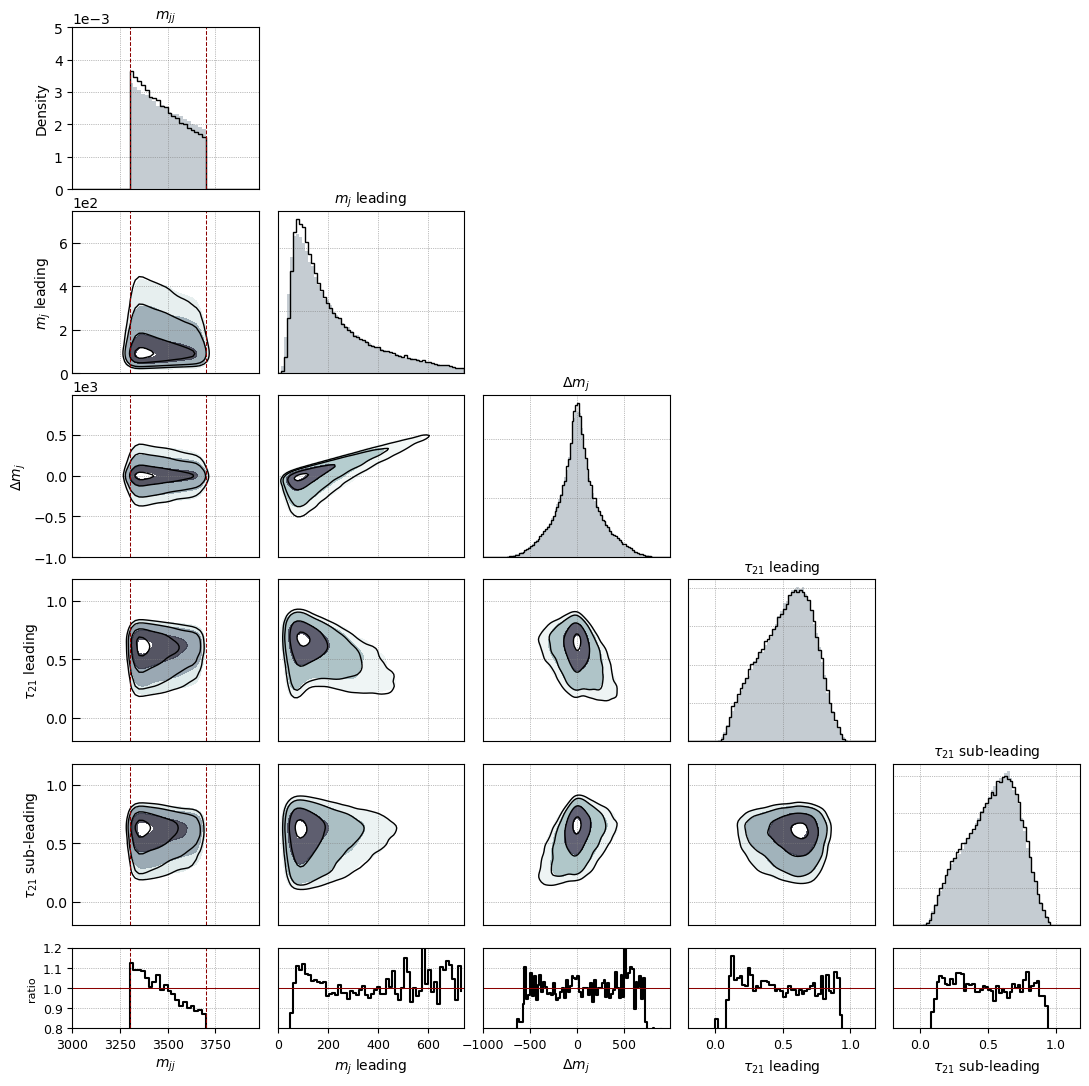

$t_f=$0.4020000100135803, $t_b=0.5910000205039978$


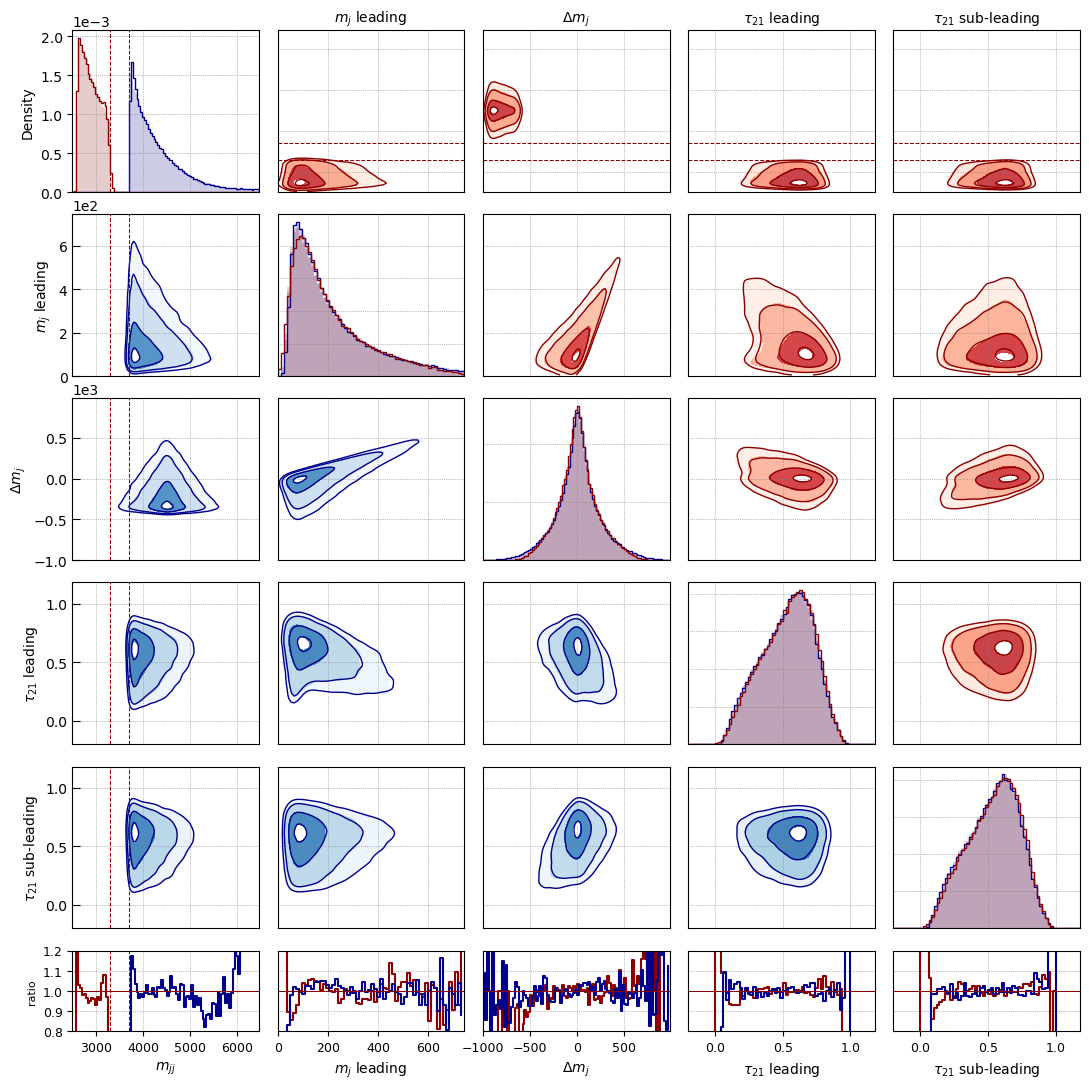

In [22]:
from utils import plot_interpolation_combined, plot_interpolation_combined_corner, plot_marginal_fits_corner

plot_interpolation_combined(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(18, 4.5),
                            mass_window=[3300, 3700], 
                            bins=[(2500, 7500, 40), (0, 1000, 15), (-1000, 1000, 20), (0, 1, 0.01), (0, 1., 0.01)], 
                            log=True, 
                            density=True,
                            save_path_fwd=model_fwd + '/interpolation_combined.png',
                            save_path_bwd=model_bwd + '/interpolation_combined.png')

plot_interpolation_combined_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                                    mass_window=[3300, 3700], 
                                    bins=[(3000, 4000, 20), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                                    log=False, 
                                    density=True,
                                    save_path_fwd=model_fwd + '/interpolation_corner_plot.pdf',
                                    save_path_bwd=model_bwd + '/interpolation_corner_plot.pdf')

plot_marginal_fits_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                            mass_window=[3300, 3700], 
                            bins=[(2500, 6500, 40), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                            log=False, 
                            density=True,
                            save_path_fwd=model_fwd + '/marginals_corner_plots.pdf',
                            save_path_bwd=model_bwd + '/marginals_corner_plots.pdf')